Problem Statement: Analyze patterns in accelerometer data to accurately classify human activities such as walking, jogging, upstairs, downstairs, sitting, and standing using machine learning techniques

Import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/activityDataset.csv', names=['user', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel'], on_bad_lines='skip')


Data Overview

In [4]:
print(df.head())


   user activity       timestamp   x_accel    y_accel       z_accel
0    33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1    33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2    33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3    33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4    33  Jogging  49106332290000 -1.184970  12.108489     7.205164;


In [5]:
print("Data Info")
print(df.info())
print("Data Description")
print(df.describe().applymap('{:,.2f}'.format))

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086466 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086466 non-null  int64  
 1   activity   1086466 non-null  object 
 2   timestamp  1086466 non-null  int64  
 3   x_accel    1086466 non-null  float64
 4   y_accel    1086466 non-null  float64
 5   z_accel    1086465 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB
None
Data Description
               user               timestamp       x_accel       y_accel
count  1,086,466.00            1,086,466.00  1,086,466.00  1,086,466.00
mean          18.84   32,502,765,659,342.09          0.66          7.25
std           10.27   48,936,485,169,723.16          6.88          6.74
min            1.00                    0.00        -19.61        -19.61
25%           10.00    1,999,712,276,000.00         -2.91          3.17
50%           19.00    9,

/tmp/ipython-input-3028142205.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df.describe().applymap('{:,.2f}'.format))


Activity Distribution: check for class imbalance

<Axes: xlabel='activity', ylabel='count'>

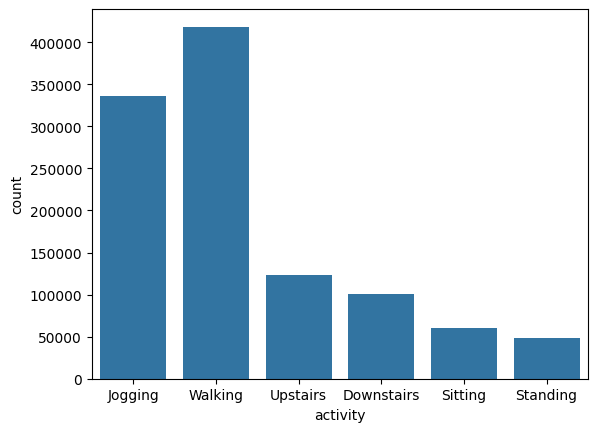

In [6]:
import seaborn as sns
sns.countplot(data=df, x='activity')


Preprocessing for Standardization and Encoding Categories

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Remove semicolons from 'z_accel' only, as x_accel and y_accel are already floats
df['z_accel'] = df['z_accel'].astype(str).str.replace(';', '', regex=False)

# Convert columns to float
df['x_accel'] = pd.to_numeric(df['x_accel'], errors='coerce')
df['y_accel'] = pd.to_numeric(df['y_accel'], errors='coerce')
df['z_accel'] = pd.to_numeric(df['z_accel'], errors='coerce')

# Drop rows with NaN values after conversion
df.dropna(inplace=True)

scaler = StandardScaler()
df[['x_accel', 'y_accel', 'z_accel']] = scaler.fit_transform(df[['x_accel', 'y_accel', 'z_accel']])

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['activity'] = encoder.fit_transform(df['activity'])


In [9]:
print(df.head())

   user  activity       timestamp   x_accel   y_accel   z_accel
0    33         1  49105962326000 -0.197600  0.806331  0.022317
1    33         1  49106062271000  0.632345  0.596159  0.116722
2    33         1  49106112167000  0.616498  0.539574 -0.100695
3    33         1  49106222305000 -0.185715  1.669250  0.551556
4    33         1  49106332290000 -0.268908  0.721454  1.429807


**Individual Axis vs. Activity**

Box Plots: Plot box plots for each axis (x, y, z) grouped by activity to see how values differ across activities.

Identify which axis is most discriminative for each activity

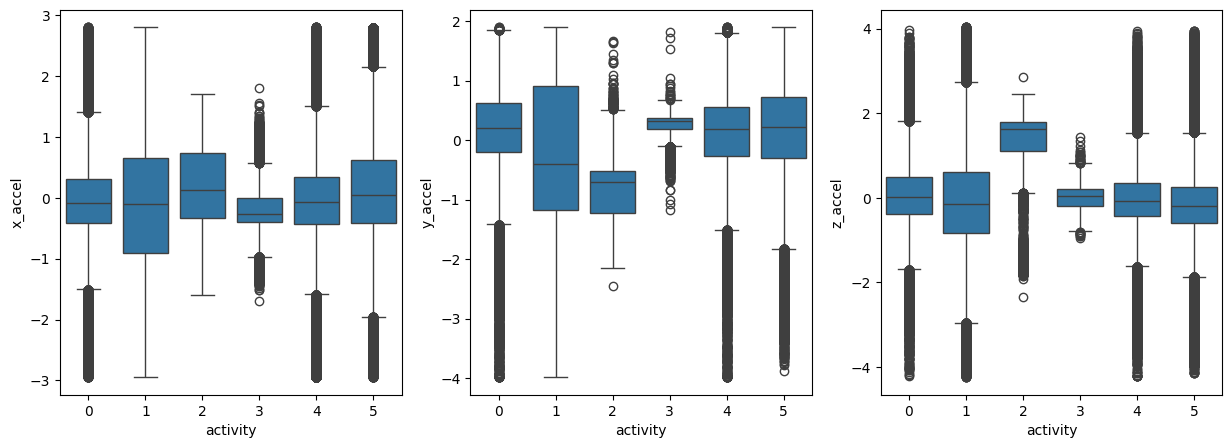

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df, x='activity', y='x_accel', ax=axes[0])
sns.boxplot(data=df, x='activity', y='y_accel', ax=axes[1])
sns.boxplot(data=df, x='activity', y='z_accel', ax=axes[2])
plt.show()


**Combined Axis Relationships**

Pair Plots: Use pair plots to visualize relationships between all three axes and how they cluster by activity.

Pairwise correlations and clustering patterns for each activity.

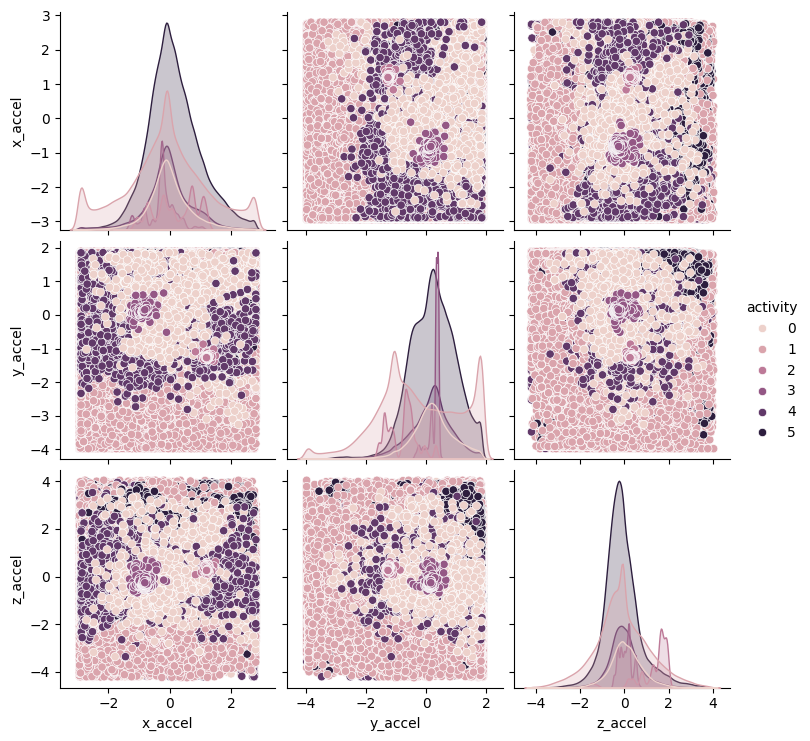

In [11]:
sns.pairplot(df, hue='activity', vars=['x_accel', 'y_accel', 'z_accel'])
plt.show()


**Time Series Plot**

Sample Time Series: Plot a short sequence of all three axes for a sample of each activity to observe temporal patterns.

Reveals how the axes behave together during each activity

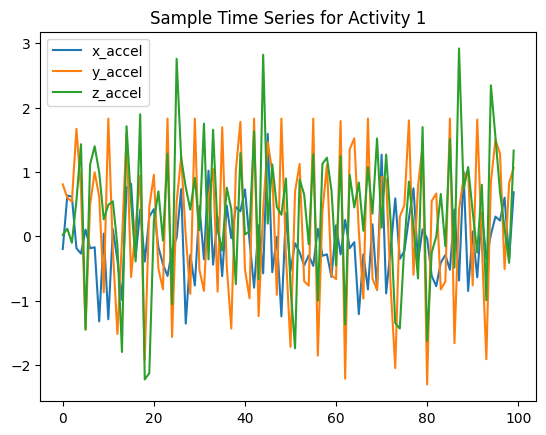

In [12]:
sample = df[df['activity'] == 1].head(100)  # Change activity for each plot
plt.plot(sample['x_accel'], label='x_accel')
plt.plot(sample['y_accel'], label='y_accel')
plt.plot(sample['z_accel'], label='z_accel')
plt.legend()
plt.title('Sample Time Series for Activity 1')
plt.show()


Through this analysis we can conclude the following points:


1.   Category 0 (Jogging): Shows large spread and many outliers in x and y (and some in z), indicating stronger, more variable acceleration compared to walking and static activities.
2.   Category 1 (Walking): Shows moderate spread in x and y, larger than sitting/standing but generally smaller than jogging
3. Category 2 (Upstairs): Shows moderate–high x and y variation, with z values shifted more towards positive and with a wider spread than static activities
4. Category 3(Downstairs): Shows moderate–high x and y variation, with z values more often negative and with a wider spread than static activities.
5. Category 4(Sitting): Shown when acceleration is low in all axis, sometimes slightly more spread than standing, reflecting different phone orientations/postures.
6. Category 5(Standing): Shown when acceleration is low in all axis with a specific value range for z higher than category 4.



Train and Test Split

In [4]:
from sklearn.model_selection import train_test_split

X = df[['x_accel', 'y_accel', 'z_accel']]
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Introducing windowed features using timestamp

In [5]:
import numpy as np
import pandas as pd

# Ensure data is ordered in time within each user
df_sorted = df.sort_values(['user', 'timestamp']).reset_index(drop=True)

WINDOW_SIZE = 40   # 2 seconds at 20 Hz
STEP_SIZE   = 20   # 50% overlap

def window_features(window):
    feats = {}
    for axis in ['x_accel', 'y_accel', 'z_accel']:
        x = window[axis].values
        feats[f'{axis}_mean']   = x.mean()
        feats[f'{axis}_std']    = x.std()
        feats[f'{axis}_min']    = x.min()
        feats[f'{axis}_max']    = x.max()
        feats[f'{axis}_energy'] = np.sum(x**2) / len(x)   # average energy
    # simple cross‑axis correlation
    feats['xy_corr'] = window['x_accel'].corr(window['y_accel'])
    feats['xz_corr'] = window['x_accel'].corr(window['z_accel'])
    feats['yz_corr'] = window['y_accel'].corr(window['z_accel'])
    return feats

rows = []
labels = []

# create windows separately per user to respect temporal structure
for (user, act), g in df_sorted.groupby(['user', 'activity']):
    g = g.reset_index(drop=True)
    n = len(g)
    for start in range(0, n - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        w = g.iloc[start:end]
        feats = window_features(w)
        feats['user'] = user
        feats['activity'] = act      # label for this window
        rows.append(feats)
        labels.append(act)

win_df = pd.DataFrame(rows)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Multinomial Logistic Regression on window‑level features

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.56      0.31      0.40       995
           1       0.92      0.95      0.94      3355
           2       0.99      0.95      0.97       592
           3       0.94      0.99      0.97       477
           4       0.58      0.36      0.45      1219
           5       0.77      0.91      0.84      4172

    accuracy                           0.81     10810
   macro avg       0.79      0.75      0.76     10810
weighted avg       0.80      0.81      0.80     10810



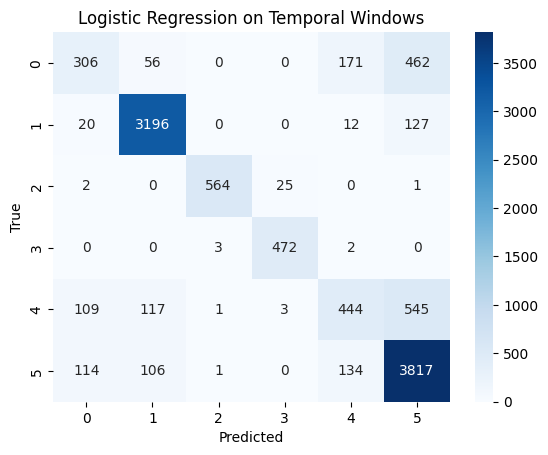

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = [c for c in win_df.columns if c not in ['activity', 'user']]
X = win_df[feature_cols]
y = win_df['activity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression on Temporal Windows')
plt.show()


Multinomial Logistic Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X = df[['x_accel', 'y_accel', 'z_accel']]
y = df['activity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # or 'median'
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20085
           1       0.51      0.46      0.48     67289
           2       0.48      0.44      0.46     11988
           3       0.00      0.00      0.00      9679
           4       0.00      0.00      0.00     24574
           5       0.46      0.81      0.59     83678

    accuracy                           0.48    217293
   macro avg       0.24      0.28      0.26    217293
weighted avg       0.36      0.48      0.40    217293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20085
           1       0.51      0.46      0.48     67289
           2       0.48      0.44      0.46     11988
           3       0.00      0.00      0.00      9679
           4       0.00      0.00      0.00     24574
           5       0.46      0.81      0.59     83678

    accuracy                           0.48    217293
   macro avg       0.24      0.28      0.26    217293
weighted avg       0.36      0.48      0.40    217293

Confusion matrix:
 [[    0  3563   257     0     0 16265]
 [    0 30671  4199     0     0 32419]
 [    0  4663  5324     0     0  2001]
 [    0   866     0     0     0  8813]
 [    0  5090   292     0     0 19192]
 [    0 15134   952     0     0 67592]]


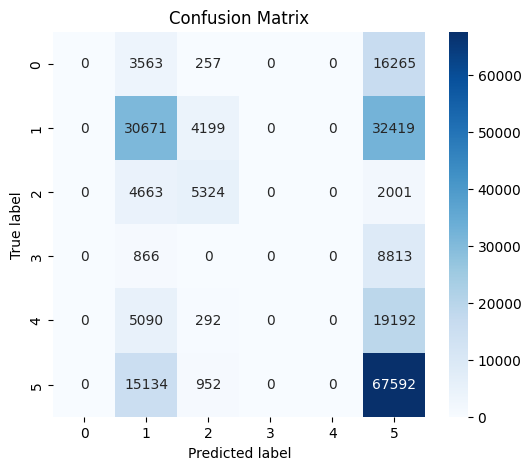

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... your existing code above ...

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix (numeric)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Optional: nicely plotted heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


Random Forest

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define X and y (assuming df is already loaded and preprocessed by previous cells)
X = df[['x_accel', 'y_accel', 'z_accel']]
y = df['activity']

# Perform train-test split to ensure X_train, y_train, X_test, y_test are defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print("Random Forest\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion matrix (Random Forest):\n", cm_rf)

# Optional heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Confusion Matrix')
plt.show()

Implementing LSTM

In [7]:
import numpy as np
import pandas as pd

# df: columns ['user','activity','timestamp','x_accel','y_accel','z_accel']
df = df.sort_values(['user', 'timestamp'])

WINDOW_SIZE = 40      # 2 seconds at 20 Hz
STEP_SIZE = 20        # 50% overlap

X_seq = []
y_seq = []

for (user, act), g in df.groupby(['user', 'activity']):
    g = g.sort_values('timestamp').reset_index(drop=True)
    data = g[['x_accel', 'y_accel', 'z_accel']].values
    n = len(data)

    for start in range(0, n - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        X_seq.append(data[start:end])  # shape (L, 3)
        y_seq.append(act)

X_seq = np.array(X_seq)     # shape (N, L, 3)
y_seq = np.array(y_seq)     # integer labels 0..5



In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

num_classes = len(np.unique(y_seq))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, 3), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,686 (76.90 KB)

 Trainable params: 19,686 (76.90 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test accuracy:", test_acc)


Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5670 - loss: 1.2136 - val_accuracy: 0.7912 - val_loss: 0.5825
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8001 - loss: 0.5684 - val_accuracy: 0.8226 - val_loss: 0.4827
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8155 - loss: 0.4927 - val_accuracy: 0.8431 - val_loss: 0.4321
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8332 - loss: 0.4445 - val_accuracy: 0.8573 - val_loss: 0.3659
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8544 - loss: 0.3870 - val_accuracy: 0.8624 - val_loss: 0.3601
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8659 - loss: 0.3543 - val_accuracy: 0.8864 - val_loss: 0.3135
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.8914 - loss: 0.3114 - val_accuracy: 0.9054 - val_loss: 0.2736
Epoch 8/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9076 - loss: 0.2704 - 